In [1]:
import torch
from torch.cuda.amp import autocast
import numpy as np
import matplotlib.pyplot as plt

(2, 5632)
(2816, 2)


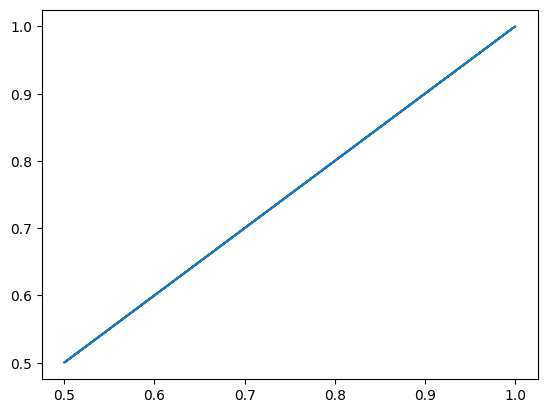

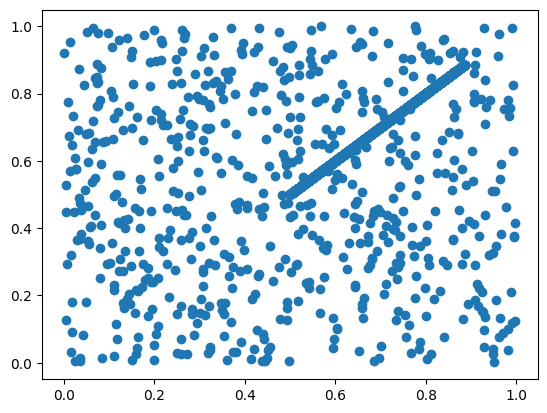

In [2]:
import random
def pattern_gen(num=64, dim=128, pattern_array_all=None):
  pattern_array_all = []
  norm = dim
  shift = np.random.rand(num)/2
  for n in range(num):
    pattern_array = []
    #pattern_array.append([shift[n]+0/norm,shift[n]+0/norm])
    for i in range((dim)//2):
      pattern_array.append([shift[n]+i/norm,shift[n]+(i+1)/norm])
      pattern_array.append([shift[n]+(i+1)/norm,shift[n]+(i+1)/norm])
    #pattern_array.append([shift[n]+((dim-2)//2)/norm,shift[n]+0/norm])
    pattern_array_all.append(np.array(pattern_array).flatten())
  return np.array(pattern_array_all)

def random_mask(pattern_array_all, random_num=0):
  pattern_array_all_rand = np.copy(pattern_array_all)
  for pattern_array in pattern_array_all_rand:
    ramdom_list = random.sample(range(pattern_array.size), random_num)
    for i in range(pattern_array.size):
      if i in ramdom_list:
        pattern_array[i] = 0
  return pattern_array_all_rand

def erase_polygon_segment(pattern_array_all, random_num=0):
  pattern_array_all_rand = np.copy(pattern_array_all)
  for pattern_array in pattern_array_all_rand:
    ramdom_list = random.sample(range(44), random_num)
    for i in range(random_num):
      # pattern_array[i*128:(i+1)*128] = np.random.rand((128)) #0
      pattern_array[len(pattern_array)-(i+1)*128:len(pattern_array)-i*128] = np.random.rand((128))
  return pattern_array_all_rand




from matplotlib.patches import Polygon

pts = pattern_gen(num=2, dim=64*44)
pattern_array_all_rand = random_mask(pts, random_num=5*44)
print(pts.shape)
#points = np.reshape(pts[0],(44, -1, 2))[0]
points = np.reshape(pts[0],(-1, 2))
print(points.shape)
#p = Polygon(points) # facecolor = 'k'
#fig,ax = plt.subplots()
#ax.add_patch(p)
plt.figure()
plt.plot(points[:,0], points[:,1])

pattern_array_all_erase = erase_polygon_segment(pts, random_num=10)
#points = np.reshape(pattern_array_all_erase[0],(44, -1, 2))[5]
points = np.reshape(pattern_array_all_erase[0],(-1, 2))
plt.figure()
plt.plot(points[:,0], points[:,1], 'o')

In [37]:
class TransformerAE(torch.nn.Module):
  def __init__(self, in_dim, d_model):
    super(TransformerAE, self).__init__()
    self.linear1 = torch.nn.Linear(in_dim, d_model)
    self.transformer1 = torch.nn.TransformerEncoderLayer(d_model=d_model, nhead=8, batch_first=True)
    self.transformer2 = torch.nn.TransformerEncoderLayer(d_model=d_model, nhead=8, batch_first=True)
    self.linear3 = torch.nn.Linear(d_model, d_model//2)
    self.linear4 = torch.nn.Linear(d_model//2, d_model)
    self.transformer3 = torch.nn.TransformerEncoderLayer(d_model=d_model, nhead=8, batch_first=True)
    self.transformer4 = torch.nn.TransformerEncoderLayer(d_model=d_model, nhead=8, batch_first=True)
    self.activation = torch.nn.ReLU()
    self.linear2 = torch.nn.Linear(d_model, in_dim)

  def forward(self, x):
    x = self.linear1(x)
    x = self.activation(x)
    x = self.transformer1(x)
    x = self.transformer2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    x = self.transformer3(x)
    x = self.transformer4(x)
    x = self.activation(x)
    x = self.linear2(x)

    return x

In [41]:
device = 'cpu'
model = TransformerAE(in_dim=128, d_model=128).to(device)

'''
for param in model.parameters():
    param.requires_grad = False
for param in model.transformer1.self_attn.parameters():
    param.requires_grad = True
for param in model.transformer2.self_attn.parameters():
    param.requires_grad = True
'''

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
loss_fn = torch.nn.L1Loss()
train_loss = []
model.train()
for i in range(100):
  # rand = torch.rand(64, 22, 128)
  reconstruct = pattern_gen(num=64, dim=64*44)  #torch.rand(64, 44, 128) #  # torch.cat((rand, rand), 1)  #torch.cat((rand, rand), 1) #
  fake_pattern = erase_polygon_segment(reconstruct, random_num=40)  #reconstruct#.copy() #torch.cat((rand, torch.rand(64, 22, 128)), 1)  # random_mask(reconstruct, random_num=10*44) #torch.cat((rand, torch.ones(64, 22, 128)), 1)

  reconstruct = np.reshape(reconstruct,(64, 44, 128))
  fake_pattern = np.reshape(fake_pattern,(64, 44, 128))
  # fake_pattern[:,:,0:64] = -100

  reconstruct = torch.Tensor(reconstruct)
  #fake_pattern = torch.Tensor(fake_pattern)
  optimizer.zero_grad()
  with autocast():
    out = model(fake_pattern.to(device))
    loss = loss_fn(out, reconstruct)
  loss.backward()
  optimizer.step()
  train_loss.append(loss.item())
  total_train_loss = sum(train_loss) / len(train_loss)
  print(f"Loss: {total_train_loss:.4f}")

<ipython-input-41-7a1547570f0f>:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


AttributeError: 'numpy.ndarray' object has no attribute 'to'

len(pattern_input):  64
[41, 19, 50]
loss:  tensor(0.2354)


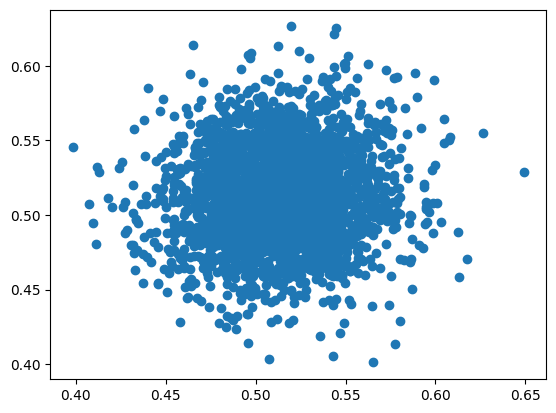

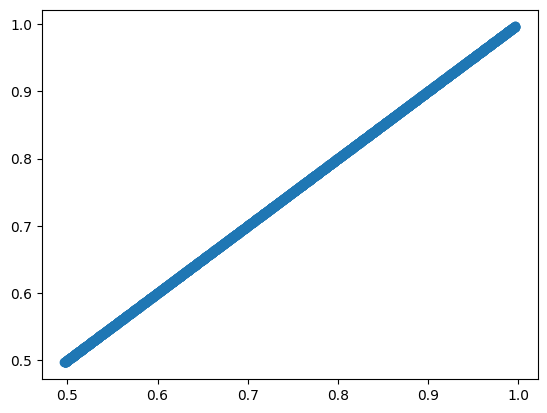

loss:  tensor(0.2134)


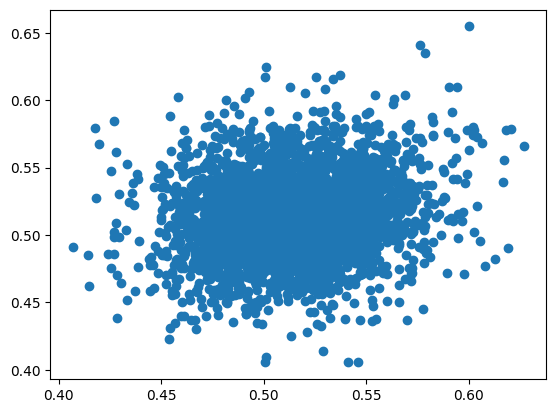

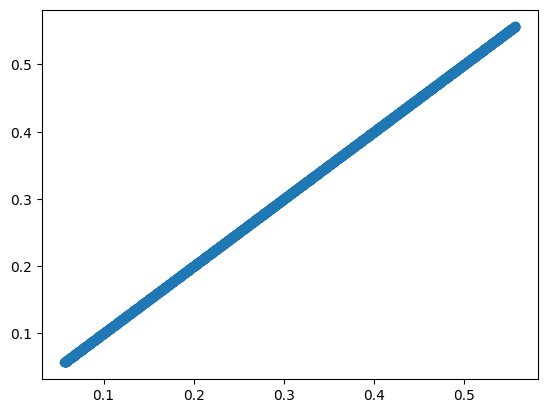

loss:  tensor(0.1998)


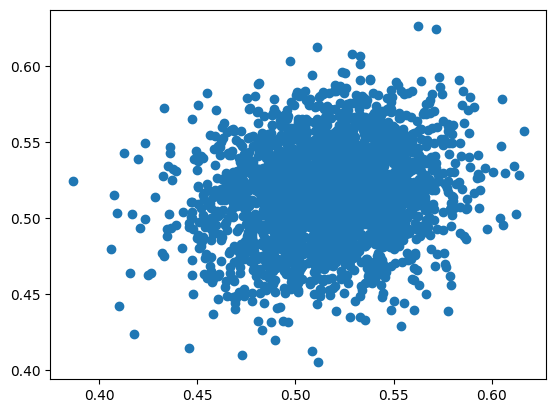

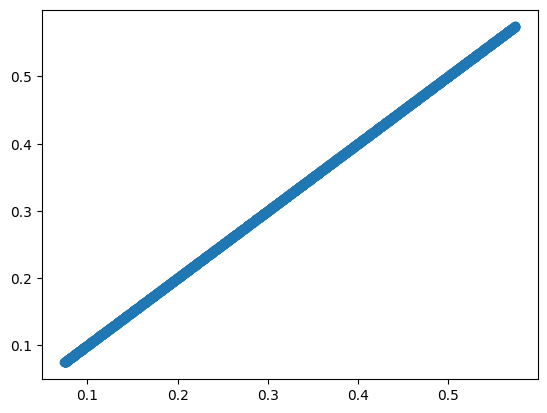

4
torch.Size([3, 44, 128])
torch.Size([3, 44, 44])


In [39]:
from typing import Optional, Any, Union, Callable
# model = TransformerAE(in_dim=44, d_model=512).to(device)
class Model_need_weights(torch.nn.Module):
  def __init__(self, model):
    super(Model_need_weights, self).__init__()
    self.model = model
    self.model.transformer1._sa_block = self._sa_block_need_weights1
    self.model.transformer2._sa_block = self._sa_block_need_weights2
    self.model.transformer3._sa_block = self._sa_block_need_weights3
    self.model.transformer4._sa_block = self._sa_block_need_weights4
    #self.model.transformer5._sa_block = self._sa_block_need_weights5
    #self.model.transformer6._sa_block = self._sa_block_need_weights6

  def _sa_block_need_weights1(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor], key_padding_mask: Optional[torch.Tensor] = None, is_causal: bool = False) -> torch.Tensor:
    x = self.model.transformer1.self_attn(x, x, x,
    attn_mask=attn_mask,
    key_padding_mask=key_padding_mask,
    need_weights=True, is_causal=is_causal)[0]

    return self.model.transformer1.dropout1(x)

  def _sa_block_need_weights2(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor], key_padding_mask: Optional[torch.Tensor] = None, is_causal: bool = False) -> torch.Tensor:
    x = self.model.transformer2.self_attn(x, x, x,
    attn_mask=attn_mask,
    key_padding_mask=key_padding_mask,
    need_weights=True, is_causal=is_causal)[0]

    return self.model.transformer2.dropout1(x)

  def _sa_block_need_weights3(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor], key_padding_mask: Optional[torch.Tensor] = None, is_causal: bool = False) -> torch.Tensor:
    x = self.model.transformer3.self_attn(x, x, x,
    attn_mask=attn_mask,
    key_padding_mask=key_padding_mask,
    need_weights=True, is_causal=is_causal)[0]

    return self.model.transformer3.dropout1(x)

  def _sa_block_need_weights4(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor], key_padding_mask: Optional[torch.Tensor] = None, is_causal: bool = False) -> torch.Tensor:
    x = self.model.transformer4.self_attn(x, x, x,
    attn_mask=attn_mask,
    key_padding_mask=key_padding_mask,
    need_weights=True, is_causal=is_causal)[0]

    return self.model.transformer4.dropout1(x)

  def _sa_block_need_weights5(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor], key_padding_mask: Optional[torch.Tensor] = None, is_causal: bool = False) -> torch.Tensor:
    x = self.model.transformer5.self_attn(x, x, x,
    attn_mask=attn_mask,
    key_padding_mask=key_padding_mask,
    need_weights=True, is_causal=is_causal)[0]

    return self.model.transformer5.dropout1(x)

  def _sa_block_need_weights6(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor], key_padding_mask: Optional[torch.Tensor] = None, is_causal: bool = False) -> torch.Tensor:
    x = self.model.transformer6.self_attn(x, x, x,
    attn_mask=attn_mask,
    key_padding_mask=key_padding_mask,
    need_weights=True, is_causal=is_causal)[0]

    return self.model.transformer6.dropout1(x)



model2 = Model_need_weights(model)

def forward_pass(pattern_input, model2, layers, device):
    attn_output = [[] for i in range(len(layers))]
    attn_output_weights = [[] for i in range(len(layers))]

    index_map = {"layer1":0, "layer2":1, "layer3":2, "layer4":3, "layer5":4, "layer6":5}
    def hook_fn_forward(module, input, output):
      ii = index_map[module.attn_name]
      attn_output[ii].append(output[0].detach().cpu())
      attn_output_weights[ii].append(output[1].detach().cpu())

    forward_hook = [None for i in range(len(layers))]
    for i in range(len(layers)):
      forward_hook[i] = layers[i].register_forward_hook(hook_fn_forward)

    loss_fn = torch.nn.L1Loss()

    # sample subset
    random.seed(7)
    indices = random.sample(range(len(pattern_input)), 3)
    print("len(pattern_input): ", len(pattern_input))
    print(indices)
    for i in indices:
      with torch.no_grad():
        out = model2.model(pattern_input[i:i+1].to(device))
        loss = loss_fn(out, pattern_input[i:i+1])
        print("loss: ", loss)
      # output
      points = np.reshape(out[0],(-1, 2))
      plt.figure()
      plt.plot(points[:,0], points[:,1], 'o')
      # original
      points = np.reshape(pattern_input[i:i+1],(-1, 2))
      plt.figure()
      plt.plot(points[:,0], points[:,1], 'o')
      plt.show()

    for i in range(len(layers)):
      forward_hook[i].remove()
      attn_output[i] = torch.cat([x for x in attn_output[i]])
      attn_output_weights[i] = torch.cat([x for x in attn_output_weights[i]])

    return attn_output, attn_output_weights

layers = []
model2.model.transformer1.self_attn.attn_name = "layer1"
model2.model.transformer2.self_attn.attn_name = "layer2"
model2.model.transformer3.self_attn.attn_name = "layer3"
model2.model.transformer4.self_attn.attn_name = "layer4"
layers.append(model2.model.transformer1.self_attn)
layers.append(model2.model.transformer2.self_attn)
layers.append(model2.model.transformer3.self_attn)
layers.append(model2.model.transformer4.self_attn)
attn_output, attn_output_weights = forward_pass(fake_pattern, model2, layers, device)

print(len(attn_output))
print(attn_output[0].size())
print(attn_output_weights[0].size()) # https://github.com/pytorch/pytorch/blob/main/torch/nn/functional.py # attn_output_weights = torch.bmm(q_scaled, k.transpose(-2, -1)) # # optionally average attention weights over heads

torch.Size([44, 128])
torch.Size([44, 128])
torch.Size([44, 128])
torch.Size([44, 128])
torch.Size([44, 44])


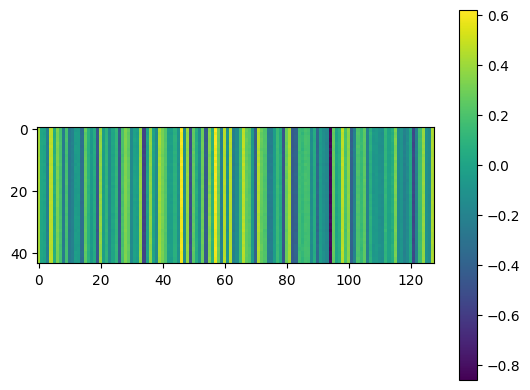

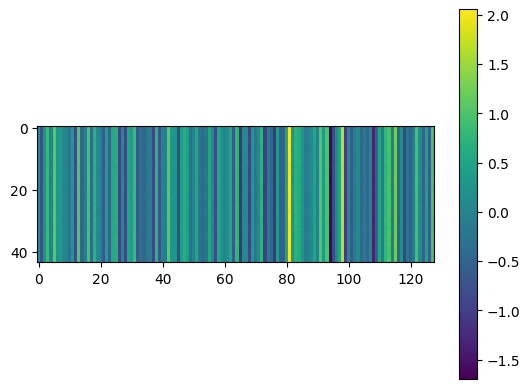

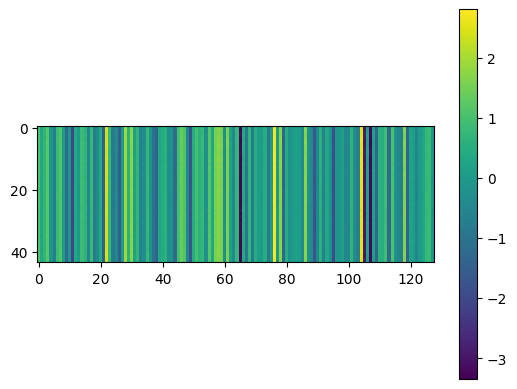

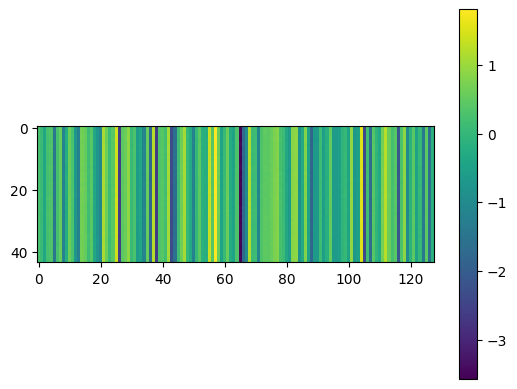

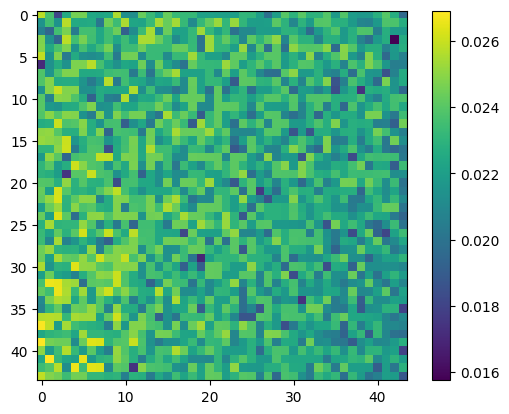

In [40]:
for i in range(len(layers)):
  attn_output_weights_avg = torch.mean(attn_output[i], dim=0)
  print(attn_output_weights_avg.size())
  plt.figure()
  plt.imshow(attn_output_weights_avg)
  plt.colorbar()

attn_output_weights_avg = torch.mean(attn_output_weights[0], dim=0)
print(attn_output_weights_avg.size())
plt.figure()
plt.imshow(attn_output_weights_avg)
plt.colorbar()

In [35]:
# cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
from numpy.linalg import matrix_power
all_simi_scores = []
print("sequence len:", len(attn_output[0][0]))
upper_index = np.triu_indices(len(attn_output[0][0]), k = 1)
for i in range(len(layers)):
  batch_num = len(attn_output[i])
  simi_scores = []
  for b in range(batch_num):
    similarity = cosine_similarity(attn_output[i][b])
    score = np.power(similarity, 2)[upper_index].mean()
    simi_scores.append(score)
  all_simi_scores.append(sum(simi_scores)/len(simi_scores))
  print(f"Layer {i}: {all_simi_scores[i]}")
print(f"Average Layer {i}: {sum(all_simi_scores)/len(all_simi_scores)}")

sequence len: 44
Layer 0: 0.9990434646606445
Layer 1: 0.966834565003713
Layer 2: 0.9799184401830038
Layer 3: 0.9948936700820923
Average Layer 3: 0.9851725349823635
